# QRNN as classifier

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import ipywidgets as w

## Training data

This notebook test whether QRNNs can be used as classifiers using a very simple test dataset.
The test datset represents a binary classification task in two dimensions. Class samples come
from two Gaussian distribution with unit covariance matrix and mean vector centered a 
$\mu_1 = [0, 0]$ and $\mu_2 = [1, 1]$.

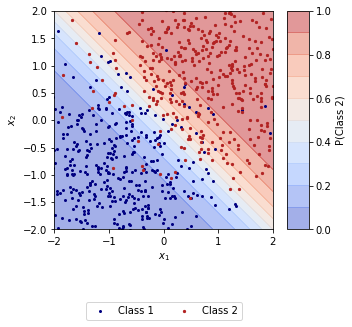

In [2]:
from regn.data import BinaryClassification
data = BinaryClassification(1000)
f = data.plot_data()

## Training

We train a QRNN and regess on the class label which is 0 for Class 1 and 1 for Class 2.

In [3]:
from typhon.retrieval.qrnn import QRNN, set_backend
set_backend("pytorch")
quantiles = [0.01, 0.05, 0.15, 0.25, 0.35, 0.45, 0.5, 0.55, 0.65, 0.75, 0.85, 0.95, 0.99]
qrnn = QRNN(2, quantiles, (4, 128, "relu"))

Using TensorFlow backend.


In [4]:
qrnn.train(data, initial_learning_rate=1e-3)

{'training_errors': [0.2539594278931618,
  0.2512592665553093,
  0.24862717992067337,
  0.246134856402874,
  0.2438998447060585,
  0.24184085673093797,
  0.24000740480422975,
  0.23832297098636626,
  0.23665966606140137,
  0.23499819868803024,
  0.23332822340726853,
  0.2316409957408905,
  0.22993591594696045,
  0.22821464467048644,
  0.22646860295534135,
  0.22468360555171968,
  0.22284386724233626,
  0.2209324198961258,
  0.21892925852537154,
  0.21681906187534333,
  0.2145789892077446,
  0.21218683871626853,
  0.20961790895462037,
  0.20684384295344352,
  0.2038307538330555,
  0.20053769040107727,
  0.19691965585947035,
  0.19292042216658592,
  0.18847257953882218,
  0.18349618163704873,
  0.17790085652470589,
  0.1716269850730896,
  0.16459371116757393,
  0.15682750168442727,
  0.14851620823144912,
  0.13992400580644607,
  0.13145367085933685,
  0.12340453651547433,
  0.11603336131572724,
  0.10943403121829033,
  0.1035688388645649,
  0.09852651256322861,
  0.09420973470807076,
  0

## Evaluate classifier

For this simple classification task, we can visualize the probability distribution that the QRNN has learned. For this we simply evaluate the classifier on a grid covering the input space. We can then display the probability distribution and compare to the true probability distribution.

In [5]:
x1, x2 = np.meshgrid(*([np.linspace(-2, 2, 101)] * 2), indexing="ij")
x = np.stack([x1, x2], axis=-1)
x = x.reshape(-1, 2)
p = qrnn.classify(x, 0.5)
p = p.reshape(101, 101)

## True probability

Assuming equal prior probabilities for both classes, the true probability is given by:

\begin{align}
P(C_2) &= \frac{\exp\{-\frac{1}{2}(\mathbf{x} - \mathbf{\mu}_2)^T(\mathbf{x} - \mathbf{\mu}_2)\}}
{\sum_{i =1}^2 \exp\{-\frac{1}{2}(\mathbf{x} - \mathbf{\mu}_i)^T(\mathbf{x} - \mathbf{\mu}_i)^T\}}
\end{align}

In [6]:
mu1 = -np.ones((1, 1, 2))
mu2 = np.ones((1, 1, 2))
x = x.reshape(101, 101, 2)
e1 = np.exp(-0.5 * np.sum((x - mu1)**2, axis=-1))
e2 = np.exp(-0.5 * np.sum((x - mu2)**2, axis=-1))
p_true = e2 / (e1 + e2)

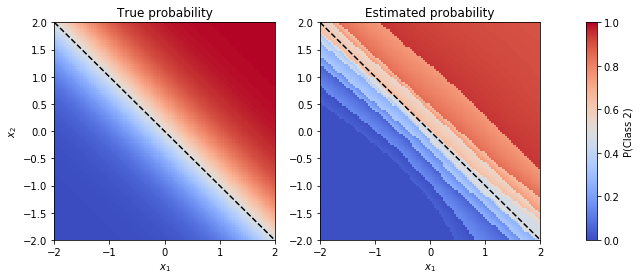

In [10]:
from matplotlib.cm import coolwarm
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec

f = plt.figure(figsize=(9, 4))
gs = GridSpec(1, 3, width_ratios=[1.0, 1.0, 0.05])
norm = Normalize(0, 1)
cmap = coolwarm

diag = np.linspace(-2, 2, 101)

ax = plt.subplot(gs[0])
ax.pcolormesh(x1, x2, p_true, cmap=cmap, norm=norm)
ax.plot(diag, diag[::-1], ls = "--", c = "k")
ax.set_title("True probability")
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")

ax = plt.subplot(gs[1])
img = ax.pcolormesh(x1, x2, p, cmap=cmap, norm=norm)
ax.plot(diag, diag[::-1], ls = "--", c = "k")
ax.set_title("Estimated probability")
ax.set_xlabel("$x_1$")

ax = plt.subplot(gs[2])
plt.colorbar(img, cax=ax, label="P(Class 2)")
plt.tight_layout()

## ROC Curve

In [15]:
from regn.utils import compute_roc
test_data = BinaryClassification(1000)
p = qrnn.classify(test_data.x, 0.5)
fpr, tpr = compute_roc(p.ravel(), test_data.y.ravel(), np.linspace(0, 1, 21))

Text(0, 0.5, 'True positive rate')

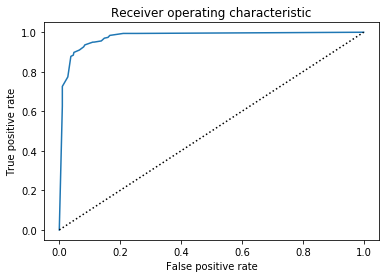

In [17]:
plt.plot(fpr, tpr)
x = np.linspace(0, 1, 1001)
plt.plot(x, x, ls = ":", c = "k")
plt.title("Receiver operating characteristic")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")